## Data Exploration and Cleaning

In this notebook, we will be using SQL for initial data exploration, filtering, and variable selection (in the case of duplicate variables pulled from the study). <br/>

We will be using Pandas and Numpy for more detailed data cleaning, imputation, decoding and re-encoding the variables from the study into relevant features, and feature engineering.

Note: most of the functions used in the notebook will be found in the EDA_Functions.py file.

### Importing Database

In [3]:
# Get pandas and postgres to work together
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# We are also going to do some basic viz
import matplotlib.pyplot as plt
%matplotlib inline

#import our own EDA functions 
from EDA_Functions import *

#make sure we can import our .py functions
%load_ext autoreload
%autoreload 2

In [5]:
connection_args = {
    'host': 'localhost',  # We are connecting to our _local_ version of psql
    'dbname': 'juliaqiao',    # DB that we are connecting to which contains all the nls data tables I've created in postgress
}

connection = pg.connect(**connection_args)

In [6]:
#load our full dataset
query = "SELECT * FROM nls;"

pd_sql.read_sql(query, connection)

,id,sex,birth_year,sample_type,race,poverty,degree_2017,marriage,metro_area,child_at_home,...,income_wage_est,income_bus_total,income_bus_est,degree_other,house_type_30,fin_assets_30,debts_30,house_type_35,fin_assets_35,debts_35
0,1,2,1981,1,4,-5,-5,-5,-5,-5,...,-5,-5,-5,4,6,30000,18000,-4,-4,-4
1,2,1,1982,1,2,929,2,2,2,-4,...,-4,-4,-4,2,6,45000,35000,1,2000,62500
2,3,2,1983,1,2,-3,4,3,2,2,...,-1,-4,-4,4,6,-3,19300,-4,-4,-4
3,4,2,1981,1,2,179,2,2,3,1,...,-4,-4,-4,2,6,0,0,6,7050,1300
4,5,1,1982,1,2,871,2,3,3,2,...,-4,-4,-4,2,1,144000,9000,1,300000,3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8979,9018,2,1980,1,4,327,1,3,2,0,...,-4,-4,-4,1,6,100,1200,1,4000,19000
8980,9019,1,1984,0,2,498,3,2,3,0,...,-4,-4,-4,3,6,400,17000,-4,-4,-4
8981,9020,1,1980,1,4,-5,-5,-5,-5,-5,...,-5,-5,-5,2,6,6000,0,6,78750,0
8982,9021,1,1980,1,4,260,4,2,2,1,...,-4,-4,-4,4,6,5000,0,6,9000,0


### Exploration

In [7]:
#counting house ownership count by category, for age 30
query_house_count_30 = """
        SELECT house_type_30, COUNT(house_type_30)
        FROM nls
        GROUP BY house_type_30
        ORDER BY COUNT(house_type_30) DESC 
"""

pd_sql.read_sql(query_house_count_30, connection)

,house_type_30,count
0,6,5352
1,1,1936
2,-4,1274
3,9,247
4,3,156
5,-3,17
6,2,2


CVC_HOUSE_TYPE_30 KEY <br/>
  1='House' <br/>
  2='Ranch/Farm' <br/>
  3='Mobile Home' <br/>
  6='R does not own' <br/>
  9='Owns other residence type'

In [8]:
#counting house ownership count by category, for age 35
query_house_count_35 = """
        SELECT house_type_35, COUNT(house_type_35)
        FROM nls
        GROUP BY house_type_35
        ORDER BY COUNT(house_type_35) DESC 
"""

pd_sql.read_sql(query_house_count_35, connection)

,house_type_35,count
0,-4,4817
1,6,2360
2,1,1617
3,9,128
4,3,46
5,-3,14
6,2,2


Interview Skip Key (from the nls_key_decoder_sas): <br/>
Noninterview -5 <br/>
Valid Skip -4 <br/>
Invalid Skip -3 <br/>
Don't Know -2 <br/>
Refusal -1 <br/>


Between age 30 and 35, it's clear that we should stick to 30 for a larger sample size, as most of the age 35 answers were valid skips (since only half of the subjects had reached 35 by the last survey).

#### Adding in additional features

In [9]:
#load our additional features
query_extra = "SELECT * FROM nls_extra;"

pd_sql.read_sql(query_extra, connection)

,id,childhood_home,childhood_poverty,own_or_rent,home_situation,moves_since_12
0,1,2,-3,5,1,1
1,2,-4,-4,4,-4,-4
2,3,2,583,4,-4,13
3,4,2,108,4,-4,5
4,5,2,-3,1,-4,9
...,...,...,...,...,...,...
8979,9018,-4,-3,4,-4,-4
8980,9019,2,-3,5,1,5
8981,9020,1,663,5,8,9
8982,9021,2,144,4,-4,13


In [23]:
#join the two tables (inner join is default join)
query_join = "SELECT * FROM nls JOIN nls_extra ON nls.id = nls_extra.id;"

pd_sql.read_sql(query_join, connection)

,id,sex,birth_year,sample_type,race,poverty,degree_2017,marriage,metro_area,child_at_home,...,debts_30,house_type_35,fin_assets_35,debts_35,id,childhood_home,childhood_poverty,own_or_rent,home_situation,moves_since_12
0,1,2,1981,1,4,-5,-5,-5,-5,-5,...,18000,-4,-4,-4,1,2,-3,5,1,1
1,2,1,1982,1,2,929,2,2,2,-4,...,35000,1,2000,62500,2,-4,-4,4,-4,-4
2,3,2,1983,1,2,-3,4,3,2,2,...,19300,-4,-4,-4,3,2,583,4,-4,13
3,4,2,1981,1,2,179,2,2,3,1,...,0,6,7050,1300,4,2,108,4,-4,5
4,5,1,1982,1,2,871,2,3,3,2,...,9000,1,300000,3000,5,2,-3,1,-4,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8979,9018,2,1980,1,4,327,1,3,2,0,...,1200,1,4000,19000,9018,-4,-3,4,-4,-4
8980,9019,1,1984,0,2,498,3,2,3,0,...,17000,-4,-4,-4,9019,2,-3,5,1,5
8981,9020,1,1980,1,4,-5,-5,-5,-5,-5,...,0,6,78750,0,9020,1,663,5,8,9
8982,9021,1,1980,1,4,260,4,2,2,1,...,0,6,9000,0,9021,2,144,4,-4,13


### Variable Duplication

Now that we have our joined tables, let's take a look at our duplicate variables. Our study had a few duplicates, so we pulled them all in to see which in particular should be used to represent each feautre.

In [10]:
#we have 2 variables from the study that could be our Y variable, so let's see which one has gathered more data.
#let's look at house_type_30 first
#interview skip keys are: [-5, -4,-3,-2,-1]

query_Y_house_type = "SELECT house_type_30, COUNT(house_type_30) FROM nls JOIN nls_extra ON nls.id = nls_extra.id WHERE house_type_30 NOT IN (-5, -4,-3,-2,-1) GROUP BY house_type_30;"

pd_sql.read_sql(query_Y_house_type, connection)

,house_type_30,count
0,2,2
1,9,247
2,6,5352
3,1,1936
4,3,156


In [11]:
#let's look at total counts of answers
query_Y_house_type = "SELECT COUNT(house_type_30) FROM nls JOIN nls_extra ON nls.id = nls_extra.id WHERE house_type_30 NOT IN (-5, -4,-3,-2,-1);"

pd_sql.read_sql(query_Y_house_type, connection)

,count
0,7693


In [10]:
#now let's look at own_or_rent
#interview skip keys are: [-5, -4,-3,-2,-1]

query_Y_house_type = "SELECT own_or_rent, COUNT(own_or_rent) FROM nls JOIN nls_extra ON nls.id = nls_extra.id WHERE own_or_rent NOT IN (-5, -4,-3,-2,-1) GROUP BY own_or_rent;"

pd_sql.read_sql(query_Y_house_type, connection)

,own_or_rent,count
0,1,750
1,3,114
2,5,2178
3,2,364
4,4,4037


In [12]:
#let's look at total counts of answers

query_Y_house_type = "SELECT COUNT(own_or_rent) FROM nls JOIN nls_extra ON nls.id = nls_extra.id WHERE own_or_rent NOT IN (-5, -4,-3,-2,-1);"

pd_sql.read_sql(query_Y_house_type, connection)

,count
0,7443


House_type_30 has a higher answer count than own_or_rent, so we will use house_type_30 as our Y variable.

In [13]:
#let's now look at our duplicate variable--degrees, to see which one is more robust and should be used as our feature
# looks like degree_2017 has a lot of skipped answers - noninterview. 
query_degree_2017 = """
        SELECT degree_2017, COUNT(degree_2017)
        FROM nls 
        JOIN nls_extra 
        ON nls.id = nls_extra.id
        WHERE house_type_30 NOT IN (-5,-4,-3,-2,-1)
        AND degree_2017 IN (-5,-4,-3,-2,-1)
        GROUP BY degree_2017
        
        
"""

pd_sql.read_sql(query_degree_2017, connection)


,degree_2017,count
0,-5,1064
1,-3,26


In [15]:
#how many skips does degree_other have? 
query_degree_other = """
        SELECT degree_other, COUNT(degree_2017)
        FROM nls 
        JOIN nls_extra 
        ON nls.id = nls_extra.id
        WHERE house_type_30 NOT IN (-5,-4,-3,-2,-1)
        AND degree_other IN (-5,-4,-3,-2,-1)
        GROUP BY degree_other
        
        
"""

pd_sql.read_sql(query_degree_other, connection)

,degree_other,count
0,-3,30


Degree_other have much fewer skips than degree_2017 -- potentially a more recent variable, so we will stick with degree_other as the education feature!

In [14]:
#let's create a df only with no skips for our Y variable question--house_type_30
#once again, interview skip keys are: [-5, -4,-3,-2,-1]
query_Y= """SELECT * 
            FROM nls 
            JOIN nls_extra 
            ON nls.id = nls_extra.id 
            WHERE house_type_30 
            NOT IN (-5, -4,-3,-2,-1);"""

joined_df = pd_sql.read_sql(query_Y, connection)

In [26]:
#pickle this starter df for later
joined_df.to_pickle('joined_df.pickle')

In [15]:
#let's see if we have any NaNs
joined_df.isnull().sum()

id                   0
sex                  0
birth_year           0
sample_type          0
race                 0
poverty              0
degree_2017          0
marriage             0
metro_area           0
child_at_home        0
urban_rural          0
income_wage_total    0
income_wage_est      0
income_bus_total     0
income_bus_est       0
degree_other         0
house_type_30        0
fin_assets_30        0
debts_30             0
house_type_35        0
fin_assets_35        0
debts_35             0
id                   0
childhood_home       0
childhood_poverty    0
own_or_rent          0
home_situation       0
moves_since_12       0
dtype: int64

#### Let's now query only the columns we need for modeling.

In [16]:
query_model = """
        SELECT nls.id, sex, birth_year, sample_type, race, 
        poverty, marriage, metro_area, child_at_home, urban_rural, 
        income_wage_total, income_wage_est, income_bus_total, income_bus_est,
        degree_other, house_type_30, fin_assets_30, debts_30, 
        childhood_home, childhood_poverty, moves_since_12  
        FROM nls 
        JOIN nls_extra 
        ON nls.id = nls_extra.id 
        WHERE house_type_30 NOT IN (-5,-4,-3,-2,-1)
        
"""

joined_clean = pd_sql.read_sql(query_model, connection)

In [34]:
#pickle it for our modeling later
joined_clean.to_pickle('joined_clean.pickle')

In [17]:
joined_clean

,id,sex,birth_year,sample_type,race,poverty,marriage,metro_area,child_at_home,urban_rural,...,income_wage_est,income_bus_total,income_bus_est,degree_other,house_type_30,fin_assets_30,debts_30,childhood_home,childhood_poverty,moves_since_12
0,1,2,1981,1,4,-5,-5,-5,-5,-5,...,-5,-5,-5,4,6,30000,18000,2,-3,1
1,2,1,1982,1,2,929,2,2,-4,0,...,-4,-4,-4,2,6,45000,35000,-4,-4,-4
2,3,2,1983,1,2,-3,3,2,2,2,...,-1,-4,-4,4,6,-3,19300,2,583,13
3,4,2,1981,1,2,179,2,3,1,1,...,-4,-4,-4,2,6,0,0,2,108,5
4,5,1,1982,1,2,871,3,3,2,1,...,-4,-4,-4,2,1,144000,9000,2,-3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7688,9018,2,1980,1,4,327,3,2,0,1,...,-4,-4,-4,1,6,100,1200,-4,-3,-4
7689,9019,1,1984,0,2,498,2,3,0,1,...,-4,-4,-4,3,6,400,17000,2,-3,5
7690,9020,1,1980,1,4,-5,-5,-5,-5,-5,...,-5,-5,-5,2,6,6000,0,1,663,9
7691,9021,1,1980,1,4,260,2,2,1,1,...,-4,-4,-4,4,6,5000,0,2,144,13


### De-coding

All of the variables are coded by the study. We need to "decode" them and re-encode them to extract what we need for our models.

In [18]:
#first, let's address the interview skips, and fill them with NaNs
#Skips = (-5, -4,-3,-2,-1)

joined_filled = joined_clean.copy()

joined_filled.replace([-5, -4,-3,-2,-1], np.nan, inplace=True)

In [ ]:
joined_filled['homeowner'] = joined_filled.apply(lambda x: owns_home(x['house_type_30']),axis=1)

### Feature Engineering - Continuous

Let's take a look at our continuous variables first:

In [163]:
continuous = ['birth_year', 'poverty', 'child_at_home', 'fin_assets_30', 'debts_30',
       'childhood_poverty', 'moves_since_12',
       'income_wage_compiled', 'income_bus_compiled']

Let's start by feature engineering our income columns. We have 4 columns--estimated and actual for salary/wages and for business/farm income. let's combine them into 2 encoded columns of estimated salary--one for wages and one for business/farm.

In [19]:
joined_filled.income_wage_est.value_counts()

3.0    112
4.0     95
2.0     50
1.0     49
5.0     43
6.0     10
7.0      4
Name: income_wage_est, dtype: int64

Income Wage Code key: <br/>
  1='A. $1 - $5,000' <br/>
  2='B. $5,001 - $10,000' <br/>
  3='C. $10,001 - $25,000' <br/>
  4='D. $25,001 - $50,000' <br/>
  5='E. $50,001 - $100,000' <br/>
  6='F. $100,001 - $250,000' <br/>
  7='G. More than $250,000' <br/>

In [20]:
#calculate median of income wages above 25k--this is an imput for our decoder function
median_25k = np.median([joined_filled['income_wage_total'] >=250000])

#create new column to store these decoded wage income values.
joined_filled['income_wage_est_decoded'] = joined_filled.apply(lambda x: income_est_decoder(x['income_wage_est'], median_25k),axis=1)

Now we want to decode our business/farm income key from our survey. However, it is slightly different than our income wage key, because 1 here stands for "lost/would lose money" instead of "$1-$5000." <br/>
Original Business/farm income encoder from source data: 

  1='A.   LOST/WOULD LOSE MONEY' <br/>
  2='B.   $1              -        $5,000' <br/>
  3='C.   $5,001       -        $10,000' <br/>
  4='D.   $10,001     -        $25,000' <br/>
  5='E.    $25,001     -        $50,000' <br/>
  6='F.    $50,001     -        $100,000' <br/>
  7='G.    $100,001   -        $250,000' <br/>
  8='H.    More than  $250,000'

In [21]:
#let's transform this key to resemble our income wage key
joined_filled['income_bus_est'] = joined_filled.apply(lambda x: income_bus_transformer(x['income_bus_est']),axis=1)


In [22]:
#calculate median of income wages above 25k--this is an imput for our decoder function
median_25k = np.median([joined_filled['income_bus_total'] >=250000])
#create new column to store these decoded business/farm income values.
joined_filled['income_bus_est_decoded'] = joined_filled.apply(lambda x: income_est_decoder(x['income_bus_est'], median_25k),axis=1)

In [23]:
joined_filled

,id,sex,birth_year,sample_type,race,poverty,marriage,metro_area,child_at_home,urban_rural,...,income_bus_est,degree_other,house_type_30,fin_assets_30,debts_30,childhood_home,childhood_poverty,moves_since_12,income_wage_est_decoded,income_bus_est_decoded
0,1,2,1981,1,4,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,6,30000.0,18000.0,2.0,NaN,1.0,NaN,NaN
1,2,1,1982,1,2,929.0,2.0,2.0,NaN,0.0,...,NaN,2.0,6,45000.0,35000.0,NaN,NaN,NaN,NaN,NaN
2,3,2,1983,1,2,NaN,3.0,2.0,2.0,2.0,...,NaN,4.0,6,NaN,19300.0,2.0,583.0,13.0,NaN,NaN
3,4,2,1981,1,2,179.0,2.0,3.0,1.0,1.0,...,NaN,2.0,6,0.0,0.0,2.0,108.0,5.0,NaN,NaN
4,5,1,1982,1,2,871.0,3.0,3.0,2.0,1.0,...,NaN,2.0,1,144000.0,9000.0,2.0,NaN,9.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7688,9018,2,1980,1,4,327.0,3.0,2.0,0.0,1.0,...,NaN,1.0,6,100.0,1200.0,NaN,NaN,NaN,NaN,NaN
7689,9019,1,1984,0,2,498.0,2.0,3.0,0.0,1.0,...,NaN,3.0,6,400.0,17000.0,2.0,NaN,5.0,NaN,NaN
7690,9020,1,1980,1,4,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,6,6000.0,0.0,1.0,663.0,9.0,NaN,NaN
7691,9021,1,1980,1,4,260.0,2.0,2.0,1.0,1.0,...,NaN,4.0,6,5000.0,0.0,2.0,144.0,13.0,NaN,NaN


In [24]:
#let's compile the newly decoded estimates and our original total column for income wages now.
joined_filled['income_wage_compiled'] = joined_filled.apply(lambda x: income_compiler(x['income_wage_total'],x['income_wage_est_decoded']),axis=1)
joined_filled.income_wage_compiled.notnull().sum()

5380

In [25]:
#sanity check--the non-null values in our compiled column is exactly the totals of the non-null values in our two individual columns
joined_filled.income_wage_est_decoded.notnull().sum() + joined_filled.income_wage_total.notnull().sum()

5380

In [26]:
#let's compile the newly decoded estimates and our original total column for income farm/business now.
joined_filled['income_bus_compiled'] = joined_filled.apply(lambda x: income_compiler(x['income_bus_total'],x['income_bus_est_decoded']),axis=1)
joined_filled.income_bus_compiled.notnull().sum()



232

In [27]:
#sanity check--the non-null values in our compiled column is exactly the totals of the non-null values in our two individual columns
joined_filled.income_bus_est_decoded.notnull().sum() + joined_filled.income_bus_total.notnull().sum()

232

In [28]:
joined_filled.columns

Index(['id', 'sex', 'birth_year', 'sample_type', 'race', 'poverty', 'marriage',
       'metro_area', 'child_at_home', 'urban_rural', 'income_wage_total',
       'income_wage_est', 'income_bus_total', 'income_bus_est', 'degree_other',
       'house_type_30', 'fin_assets_30', 'debts_30', 'childhood_home',
       'childhood_poverty', 'moves_since_12', 'income_wage_est_decoded',
       'income_bus_est_decoded', 'income_wage_compiled',
       'income_bus_compiled'],
      dtype='object')

In [29]:
#drop any columns we don't need during modeling
joined_filled = joined_filled.drop(columns =['income_wage_total','income_wage_est', 
                                            'income_bus_total', 'income_bus_est',
                                            'income_wage_est_decoded', 'income_bus_est_decoded',])

                                
       

In [83]:
joined_filled

,id,sex,birth_year,sample_type,race,poverty,marriage,metro_area,child_at_home,urban_rural,degree_other,house_type_30,fin_assets_30,debts_30,childhood_home,childhood_poverty,moves_since_12,homeowner,income_wage_compiled,income_bus_compiled
0,1,2,1981,1,4,NaN,NaN,NaN,NaN,NaN,4.0,6,30000.0,18000.0,2.0,NaN,1.0,0,NaN,NaN
1,2,1,1982,1,2,929.0,2.0,2.0,NaN,0.0,2.0,6,45000.0,35000.0,NaN,NaN,NaN,0,116000.0,NaN
2,3,2,1983,1,2,NaN,3.0,2.0,2.0,2.0,4.0,6,NaN,19300.0,2.0,583.0,13.0,0,NaN,NaN
3,4,2,1981,1,2,179.0,2.0,3.0,1.0,1.0,2.0,6,0.0,0.0,2.0,108.0,5.0,0,45000.0,NaN
4,5,1,1982,1,2,871.0,3.0,3.0,2.0,1.0,2.0,1,144000.0,9000.0,2.0,NaN,9.0,1,125000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7688,9018,2,1980,1,4,327.0,3.0,2.0,0.0,1.0,1.0,6,100.0,1200.0,NaN,NaN,NaN,0,17500.0,NaN
7689,9019,1,1984,0,2,498.0,2.0,3.0,0.0,1.0,3.0,6,400.0,17000.0,2.0,NaN,5.0,0,35000.0,NaN
7690,9020,1,1980,1,4,NaN,NaN,NaN,NaN,NaN,2.0,6,6000.0,0.0,1.0,663.0,9.0,0,NaN,NaN
7691,9021,1,1980,1,4,260.0,2.0,2.0,1.0,1.0,4.0,6,5000.0,0.0,2.0,144.0,13.0,0,35000.0,NaN


In [84]:
#pickle it for our next notebook on modeling!
joined_filled.to_pickle('joined_filled_income_cont.pickle')

### Homeowner breakdown

Before we move onto categorical variables, let's plot an pie chart to see the proportion of millenials who own vs don't own homes, and how their type of home serves the problem we're trying to solve, which is pinpointing the millenial home owners that brands--marketers, product leads, etc-- can reach.

In [30]:

#based on house type
#let's get the percentages of each type
joined_filled.house_type_30.value_counts()


6    5352
1    1936
9     247
3     156
2       2
Name: house_type_30, dtype: int64

Here is the key for house type: <br/>
  1='House' <br/>
  2='Ranch/Farm' <br/>
  3='Mobile Home' <br/>
  6='R does not own' <br/>
  9='Owns other residence type'

In [36]:
# There is a bug in matplotlib. You cannot set the rc parameters in the same
# cell that you use the "%matplotlib inline" magic command
plt.style.use('ggplot')
plt.rc('font', size=14)

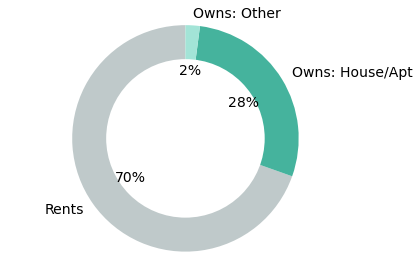

In [45]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Rents', 'Owns: House/Apt', 'Owns: Other'
sizes = [(5352/7693), ((1936+247)/7693), ((156+2)/7693)]
colors = ['#BFC9CA','#45B39D','#A3E4D7']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%.f%%', startangle=90, colors = colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#draw circle
centre_circle = plt.Circle((0,0),0.7,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.tight_layout()

plt.savefig('piechart.png', dpi=300);

For this model for marketers, we're only interested in permanent homes that are primary residences, with permanent residences, and not large scale business operations, so we can exclude farms/ranches and mobile homes.

In [134]:
#let's create a new column to focus on our more specialized Y variable.
joined_filled['homeowner_perm'] = joined_filled.apply(lambda x: owns_perm_home(x['house_type_30']),axis=1)

In [136]:
joined_filled.columns

Index(['id', 'sex', 'birth_year', 'sample_type', 'race', 'poverty', 'marriage',
       'metro_area', 'child_at_home', 'urban_rural', 'degree_other',
       'house_type_30', 'fin_assets_30', 'debts_30', 'childhood_home',
       'childhood_poverty', 'moves_since_12', 'homeowner',
       'income_wage_compiled', 'income_bus_compiled', 'homeowner_perm'],
      dtype='object')

### Categorical Variables: Enocoding and Engineering

We will be engineering the categorial variables in this next section.

Let's now look at our categorial features and understand which ones we can easily use one hot encode and which we will need to manually encode (due to the complexity of the study's feature keys and the precense of NaNs). 


In [141]:
#listing out our categorical variables
categorical = ['sex', 'sample_type', 'race', 'marriage',
       'metro_area', 'urban_rural', 'degree_other','childhood_home']

cat_ohe = ['sex', 'race']

In [144]:
ohe = OneHotEncoder(sparse = False)

cat = ohe.fit_transform(joined_filled.loc[: , cat_ohe])

In [146]:
cat_df = pd.DataFrame(cat, columns=ohe.get_feature_names(cat_ohe), index = joined_filled.index)

In [157]:
joined_filled = joined_filled.join(cat_df)

sex_1 = male
sex_2 = female
race_1 = black
race_2 = hispanic
race_3 = mixed race 
race_4 = not black, hispanic, or mixed

In [158]:
#drop the last categorical in each category
joined_filled = joined_filled.drop(columns =['sex_2', 'race_4'])

In [159]:
#rename the columns for ease of interpretation
joined_filled = joined_filled.rename({'sex_1': 'is_male', 'race_1': 'is_black', 'race_2': 'is_hispanic', 'race_3': 'is_mixed'}, axis=1)


In [160]:
joined_filled

,id,sex,birth_year,sample_type,race,poverty,marriage,metro_area,child_at_home,urban_rural,...,childhood_poverty,moves_since_12,homeowner,income_wage_compiled,income_bus_compiled,homeowner_perm,is_male,is_black,is_hispanic,is_mixed
0,1,2,1981,1,4,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,0,NaN,NaN,0,0.0,0.0,0.0,0.0
1,2,1,1982,1,2,929.0,2.0,2.0,NaN,0.0,...,NaN,NaN,0,116000.0,NaN,0,1.0,0.0,1.0,0.0
2,3,2,1983,1,2,NaN,3.0,2.0,2.0,2.0,...,583.0,13.0,0,NaN,NaN,0,0.0,0.0,1.0,0.0
3,4,2,1981,1,2,179.0,2.0,3.0,1.0,1.0,...,108.0,5.0,0,45000.0,NaN,0,0.0,0.0,1.0,0.0
4,5,1,1982,1,2,871.0,3.0,3.0,2.0,1.0,...,NaN,9.0,1,125000.0,NaN,1,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7688,9018,2,1980,1,4,327.0,3.0,2.0,0.0,1.0,...,NaN,NaN,0,17500.0,NaN,0,0.0,0.0,0.0,0.0
7689,9019,1,1984,0,2,498.0,2.0,3.0,0.0,1.0,...,NaN,5.0,0,35000.0,NaN,0,1.0,0.0,1.0,0.0
7690,9020,1,1980,1,4,NaN,NaN,NaN,NaN,NaN,...,663.0,9.0,0,NaN,NaN,0,1.0,0.0,0.0,0.0
7691,9021,1,1980,1,4,260.0,2.0,2.0,1.0,1.0,...,144.0,13.0,0,35000.0,NaN,0,1.0,0.0,0.0,0.0


In [ ]:
#now we have the below variables for manual encoding
manual_encoding = ['marriage',
                    'metro_area', 
                    'urban_rural', 
                    'degree_other',
                    'childhood_home']

In [162]:
joined_filled.marriage.value_counts()

3.0     2856
2.0     1905
1.0      819
8.0      416
7.0      234
4.0      163
6.0      107
5.0       44
10.0      19
9.0        4
Name: marriage, dtype: int64

Maritial status: <br/>
  1='Never married, cohabiting' <br/>
  2='Never married, not cohabiting' <br/>
  3='Married, spouse present' <br/>
  4='Married, spouse absent' <br/>
  5='Separated, cohabiting' <br/>
  6='Separated, not cohabiting' <br/>
  7='Divorced, cohabiting' <br/>
  8='Divorced, not cohabiting' <br/>
  9='Widowed, cohabiting' <br/>
  10='Widowed, not cohabiting' <br/>

The marital status category is extremely detailed, but for the purposes of our model, we only care about whether the couple is married or cohabitating as these two situations most strongly imply either the merging of financial and/or real estate assets. Those who are married, cohabitating, or both, are also more likely to purchase homes based on domain knowledge. We will be encoding both of these values with 1.  

In [168]:
#let's create a new column to signify marital status = currently married.
joined_filled['is_married'] = joined_filled.apply(lambda x: married(x['marriage']),axis=1)

In [176]:
#let's create a new column to signify cohabitation status = currently cohabitating (regardless of relationship status).
joined_filled['is_cohab'] = joined_filled.apply(lambda x: cohabitating(x['marriage']),axis=1)

Now let's look at metro_area and urban_rural breakdown.

Metro_area key (CBSA as defined by census) <br/>
  1='Not in CBSA'<br/>
  2='In CBSA, not in central city'<br/>
  3='In CBSA, in central city'<br/>
  4='In CBSA, not known'<br/>
  5='Not in country'<br/>

Urban_rural key<br/>
  0='Rural'<br/>
  1='Urban'<br/>
  2='Unknown'<br/>


For the purposes of our model, we're only interested in anyone who's in CBSA, or in the central city, which already encompasses more specificity than an urban or rural area breakdown, so we'll focus on the metro_area variable for now.  

In [189]:
#let's create a new column to signify CBSA (metro_area) residential status.
joined_filled['is_metro'] = joined_filled.apply(lambda x: metro(x['metro_area']),axis=1)

In [190]:
#let's create a new column to signify central city residential status.
joined_filled['is_central'] = joined_filled.apply(lambda x: central_city(x['metro_area']),axis=1)

,id,sex,birth_year,sample_type,race,poverty,marriage,metro_area,child_at_home,urban_rural,...,income_bus_compiled,homeowner_perm,is_male,is_black,is_hispanic,is_mixed,is_married,is_cohab,is_metro,is_central
3,4,2,1981,1,2,179.0,2.0,3.0,1.0,1.0,...,NaN,0,0.0,0.0,1.0,0.0,0,0,1,1
4,5,1,1982,1,2,871.0,3.0,3.0,2.0,1.0,...,NaN,1,1.0,0.0,1.0,0.0,1,1,1,1
5,6,2,1982,1,2,226.0,3.0,3.0,2.0,1.0,...,NaN,0,0.0,0.0,1.0,0.0,1,1,1,1
8,9,1,1982,1,4,989.0,3.0,3.0,NaN,1.0,...,NaN,0,1.0,0.0,0.0,0.0,1,1,1,1
9,10,1,1984,1,4,906.0,3.0,3.0,1.0,1.0,...,NaN,0,1.0,0.0,0.0,0.0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7680,9009,1,1980,1,4,624.0,3.0,3.0,4.0,1.0,...,NaN,1,1.0,0.0,0.0,0.0,1,1,1,1
7684,9013,1,1982,0,1,140.0,2.0,3.0,0.0,1.0,...,NaN,0,1.0,1.0,0.0,0.0,0,0,1,1
7685,9014,2,1984,0,1,55.0,2.0,3.0,2.0,1.0,...,NaN,0,0.0,1.0,0.0,0.0,0,0,1,1
7687,9016,2,1982,0,1,223.0,2.0,3.0,NaN,1.0,...,NaN,1,0.0,1.0,0.0,0.0,0,0,1,1


Now let's look at childhood homes. We're interested in those whose childhood homes were owned homes, in order to explore whether a subject's family's home ownership during their childhood has an impact on their own home ownership in adulthood.

Childhood home variable key: <br/>
  1='OWNS OR IS BUYING; LAND CONTRACT' <br/>
  2='PAYS RENT' <br/>
  3='NEITHER OWNS NOR RENTS' <br/>

In [204]:
#let's create a new column to signify childhood (family) home ownership.
joined_filled['childhood_owned'] = joined_filled.apply(lambda x: childhood_owned(x['childhood_home']),axis=1)

Our last categorical variable is education level: <br/>
Highest degree achieved key: </br>
  0='None' <br/>
  1='GED' <br/>
  2='High school diploma (Regular 12 year program)' <br/>
  3='Associate/Junior college (AA)' <br/>
  4='Bachelor''s degree (BA, BS)' <br/>
  5='Master''s degree (MA, MS)' <br/>
  6='PhD' <br/>
  7='Professional degree (DDS, JD, MD)' <br/>


In [215]:
#let's look at the number of nulls
joined_filled.degree_other.isnull().sum()

30

The number of non-responses for the highest degree achieved question in the study is only 3% of our entire sample. Since education is not continuous and varies significantly depending on individual circumstances, imputation may not be the best idea. According to research, 10% of the U.S. does not finish high school, which is the lowest category available here, so these 30 subjects may fall into that category. Either way, we will assign them 0, as we cannot assume that they fall into the other education categories without further evidence of their childhoods, which our model features are not focused on.

In [5]:
#let's pickle our current data frame in case we get more information and can fill NA another way in the future
joined_filled.to_pickle('joined_filled_cleaned_before_filling_NaN.pickle')
#joined_filled = pd.read_pickle('joined_filled_cleaned_before_filling_NaN.pickle')
joined_filled



,id,sex,birth_year,sample_type,race,poverty,marriage,metro_area,child_at_home,urban_rural,...,homeowner_perm,is_male,is_black,is_hispanic,is_mixed,is_married,is_cohab,is_metro,is_central,childhood_owned
0,1,2,1981,1,4,NaN,NaN,NaN,NaN,NaN,...,0,0.0,0.0,0.0,0.0,0,0,0,0,0
1,2,1,1982,1,2,929.0,2.0,2.0,NaN,0.0,...,0,1.0,0.0,1.0,0.0,0,0,1,0,0
2,3,2,1983,1,2,NaN,3.0,2.0,2.0,2.0,...,0,0.0,0.0,1.0,0.0,1,1,1,0,0
3,4,2,1981,1,2,179.0,2.0,3.0,1.0,1.0,...,0,0.0,0.0,1.0,0.0,0,0,1,1,0
4,5,1,1982,1,2,871.0,3.0,3.0,2.0,1.0,...,1,1.0,0.0,1.0,0.0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7688,9018,2,1980,1,4,327.0,3.0,2.0,0.0,1.0,...,0,0.0,0.0,0.0,0.0,1,1,1,0,0
7689,9019,1,1984,0,2,498.0,2.0,3.0,0.0,1.0,...,0,1.0,0.0,1.0,0.0,0,0,1,1,0
7690,9020,1,1980,1,4,NaN,NaN,NaN,NaN,NaN,...,0,1.0,0.0,0.0,0.0,0,0,0,0,1
7691,9021,1,1980,1,4,260.0,2.0,2.0,1.0,1.0,...,0,1.0,0.0,0.0,0.0,0,0,1,0,0


In [6]:
#fill Na values for degree_other feature
joined_filled.degree_other.fillna(0, inplace = True)

In [7]:
#int(joined_filled.degree_other)
joined_filled['degree_other'] = joined_filled.apply(lambda x: int(x['degree_other']),axis=1)

joined_filled['degree_other']

0       4
1       2
2       4
3       2
4       2
       ..
7688    1
7689    3
7690    2
7691    4
7692    5
Name: degree_other, Length: 7693, dtype: int64

In [35]:
#get dummies for degree_other, dropping first dummy column (0--no degree)
degree_cat = pd.get_dummies(joined_filled['degree_other'], drop_first = True)
degree_cat

,1,2,3,4,5,6,7
0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
7688,1,0,0,0,0,0,0
7689,0,0,1,0,0,0,0
7690,0,1,0,0,0,0,0
7691,0,0,0,1,0,0,0


In [38]:
degree_cat.columns = ['GED','High_School','Assc_College', 'Bachelors','Masters', 'PhD', 'Med_Law']

In [39]:
degree_cat

,GED,High_School,Assc_College,Bachelors,Masters,PhD,Med_Law
0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
7688,1,0,0,0,0,0,0
7689,0,0,1,0,0,0,0
7690,0,1,0,0,0,0,0
7691,0,0,0,1,0,0,0


In [44]:
#join with original dataframe
joined_filled= joined_filled.join(degree_cat)


In [45]:

joined_filled

,id,sex,birth_year,sample_type,race,poverty,marriage,metro_area,child_at_home,urban_rural,...,is_metro,is_central,childhood_owned,GED,High_School,Assc_College,Bachelors,Masters,PhD,Med_Law
0,1,2,1981,1,4,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
1,2,1,1982,1,2,929.0,2.0,2.0,NaN,0.0,...,1,0,0,0,1,0,0,0,0,0
2,3,2,1983,1,2,NaN,3.0,2.0,2.0,2.0,...,1,0,0,0,0,0,1,0,0,0
3,4,2,1981,1,2,179.0,2.0,3.0,1.0,1.0,...,1,1,0,0,1,0,0,0,0,0
4,5,1,1982,1,2,871.0,3.0,3.0,2.0,1.0,...,1,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7688,9018,2,1980,1,4,327.0,3.0,2.0,0.0,1.0,...,1,0,0,1,0,0,0,0,0,0
7689,9019,1,1984,0,2,498.0,2.0,3.0,0.0,1.0,...,1,1,0,0,0,1,0,0,0,0
7690,9020,1,1980,1,4,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,1,0,0,0,0,0
7691,9021,1,1980,1,4,260.0,2.0,2.0,1.0,1.0,...,1,0,0,0,0,0,1,0,0,0


### Null values

Now that we have decoded all of our variables and created dummy columns for our categorical variables, we need to take a look at all of the null values in our columns and fill them in to the best of our ability.

In [70]:
#First, lets make a new df with only the features that we will be using in our modeling, including most of the categorical variables we now have dummys for.
joined_filled.columns

Index(['id', 'sex', 'birth_year', 'sample_type', 'race', 'poverty', 'marriage',
       'metro_area', 'child_at_home', 'urban_rural', 'degree_other',
       'house_type_30', 'fin_assets_30', 'debts_30', 'childhood_home',
       'childhood_poverty', 'moves_since_12', 'homeowner',
       'income_wage_compiled', 'income_bus_compiled', 'homeowner_perm',
       'is_male', 'is_black', 'is_hispanic', 'is_mixed', 'is_married',
       'is_cohab', 'is_metro', 'is_central', 'childhood_owned', 'GED',
       'High_School', 'Assc_College', 'Bachelors', 'Masters', 'PhD',
       'Med_Law'],
      dtype='object')

In [71]:
model_df = joined_filled.drop(columns = ['race', 'marriage',
       'metro_area', 'urban_rural', 'degree_other',
       'house_type_30', 'childhood_home'])

In [75]:
#pickle for later
model_df.to_pickle('model_df.pickle')

In [72]:
#list out our columns with null values
for column in model_df.columns:
    nulls = model_df[str(column)].isnull().sum()
    if nulls > 0:
        print ("{} : {}".format(column, nulls))

poverty : 1731
child_at_home : 2972
fin_assets_30 : 684
debts_30 : 245
childhood_poverty : 2026
moves_since_12 : 1092
income_wage_compiled : 2313
income_bus_compiled : 7461


Now let's see, out of these nulls indicating nonresponses, from our original dataframe, which ones are noninterviews (defined by the study as those unable to be located, refusal, deceased), valid skips (which are due to subjects not eligible for that question), or which ones are invalid skips(due to survey flow error on the part of the researchers causing subjects to accidentally skip a question), and 'don't know/refusal to answer' (which we can impute with an average if possible).

Interview Skip Key (from the nls_key_decoder_sas): <br/>
Noninterview -5 <br/>
Valid Skip -4 <br/>
Invalid Skip -3 <br/>
Don't Know -2 <br/>
Refusal -1 <br/>

In [97]:
#read in our original df with the interview skip keys for each column (before we filled those in with NaN)
original_df = pd.read_pickle('joined_df.pickle')
original_df

,id,sex,birth_year,sample_type,race,poverty,degree_2017,marriage,metro_area,child_at_home,...,debts_30,house_type_35,fin_assets_35,debts_35,id,childhood_home,childhood_poverty,own_or_rent,home_situation,moves_since_12
0,1,2,1981,1,4,-5,-5,-5,-5,-5,...,18000,-4,-4,-4,1,2,-3,5,1,1
1,2,1,1982,1,2,929,2,2,2,-4,...,35000,1,2000,62500,2,-4,-4,4,-4,-4
2,3,2,1983,1,2,-3,4,3,2,2,...,19300,-4,-4,-4,3,2,583,4,-4,13
3,4,2,1981,1,2,179,2,2,3,1,...,0,6,7050,1300,4,2,108,4,-4,5
4,5,1,1982,1,2,871,2,3,3,2,...,9000,1,300000,3000,5,2,-3,1,-4,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7688,9018,2,1980,1,4,327,1,3,2,0,...,1200,1,4000,19000,9018,-4,-3,4,-4,-4
7689,9019,1,1984,0,2,498,3,2,3,0,...,17000,-4,-4,-4,9019,2,-3,5,1,5
7690,9020,1,1980,1,4,-5,-5,-5,-5,-5,...,0,6,78750,0,9020,1,663,5,8,9
7691,9021,1,1980,1,4,260,4,2,2,1,...,0,6,9000,0,9021,2,144,4,-4,13


Let's tackle noninterviews first, coded by -5, and defined as those unable to be located, refusal, deceased by the study. The logitutional study occured over the course of 20 years, when subjects were 14-17 in 1997, participating under as teenagers at the time, under the supervision of their guardians.  We are looking at a snapshot from their most recent interviews in 2017. It is not surprising that a portion of thse subjects dropped off the study over the course of a decade. Noninterviews thus impact every feature, so we will need to drop them. 

In [197]:
#create a new df with only the variables we need to impute from the original df.

skips_df= original_df[['id', 'poverty', 'child_at_home', 'fin_assets_30', 'debts_30', 'childhood_poverty', 'moves_since_12']]

In [126]:
skips_df

,id,id,poverty,child_at_home,fin_assets_30,debts_30,childhood_poverty,moves_since_12
0,1,1,-5,-5,30000,18000,-3,1
1,2,2,929,-4,45000,35000,-4,-4
2,3,3,-3,2,-3,19300,583,13
3,4,4,179,1,0,0,108,5
4,5,5,871,2,144000,9000,-3,9
...,...,...,...,...,...,...,...,...
7688,9018,9018,327,0,100,1200,-3,-4
7689,9019,9019,498,0,400,17000,-3,5
7690,9020,9020,-5,-5,6000,0,663,9
7691,9021,9021,260,1,5000,0,144,13


In [198]:
#drop all rows with noninterview key in any column
skips_df=skips_df.replace(-5,np.nan).dropna(axis = 0, how = 'any')

In [199]:
skips_df

,id,id,poverty,child_at_home,fin_assets_30,debts_30,childhood_poverty,moves_since_12
1,2,2,929.0,-4.0,45000,35000,-4,-4
2,3,3,-3.0,2.0,-3,19300,583,13
3,4,4,179.0,1.0,0,0,108,5
4,5,5,871.0,2.0,144000,9000,-3,9
5,6,6,226.0,2.0,3500,1000,-3,9
...,...,...,...,...,...,...,...,...
7687,9016,9016,223.0,-4.0,530,42400,194,6
7688,9018,9018,327.0,0.0,100,1200,-3,-4
7689,9019,9019,498.0,0.0,400,17000,-3,5
7691,9021,9021,260.0,1.0,5000,0,144,13


Now let's look at the other skip breakdowns for each column:

Keep in mind, according to the study, here are the best practices for dealing with refusals, don't knows, or invalid skips:
"Samples Generated by Dropping Observations with Item Nonresponses: Often users confine their analysis to subsamples of respondents who provided valid answers to certain questions... Item nonresponse due to refusals, don't knows, or invalid skips is usually quite small, so the degree to which the weights are incorrect is probably quite small. In the event that item nonresponse constitutes a small proportion of the variables under analysis, population estimates (i.e., weighted sample means, medians, and proportions) are reasonably accurate. However, population estimates based on data items that have relatively high nonresponse rates--such as family income--may not necessarily be representative of the underlying population of the cohort under analysis."

It's up to our judgement to drop any "refusals", "don't knows", "invalid skips" or to keep inpute them with an average of the sample population. As the study has said--because these skips are quite small, dropping them would not negatively impact the degree to which our sample is reflective of the overall population. Furthermore, imputation for variables with high nonresponsive rates (many of which are financial based on my eda), may not be representative. Since financial variables are 4 out of 6 of the variables we're currently looking to clean, imputation would not be a good strategy.

**Our action plan: drop "refusals", "don't knows", "invalid skips" and dig deeper into the "valid skips" for each variable.**

Interview Skip Key (from the nls_key_decoder_sas): <br/>
Noninterview -5 <br/>
Valid Skip -4 <br/>
Invalid Skip -3 <br/>
Don't Know -2 <br/>
Refusal -1 <br/>

Let's start with non-financial features

In [200]:
interview_skips(skips_df['child_at_home'])

Valid_skips : 1889
Invalid_skips : 19
Don't Know : 0
Refusal : 0


For child_at_home (defined as number of the subject's biological children living in the subject's household), we have a large number of valid skips--the valid skips are from those who aren't qualified for this question, so we can assume that they have 0 biological children at home and impute as such. We also have a very small number of invalid skips and we will drop those after we look at every feature, together.

In [201]:
#imput all valid skips (-4) with 0.
skips_df.loc[skips_df.child_at_home == -4, 'child_at_home'] = 0

In [202]:
interview_skips(skips_df['moves_since_12'])

Valid_skips : 740
Invalid_skips : 175
Don't Know : 0
Refusal : 0


For moves_since_12 (defined as the number of different residences the subject has had since they were 12),we have a number of valid skips--the valid skips are from those who aren't qualified for this question, so we can assume that they have experienced 0 moves and impute as such. We also have a (smaller) number of invalid skips, and we will drop those after we look at every feature, together.

In [203]:
skips_df.loc[skips_df.moves_since_12 == -4, 'moves_since_12'] = 0

In [204]:
interview_skips(skips_df['poverty'])

Valid_skips : 0
Invalid_skips : 667
Don't Know : 0
Refusal : 0


For poverty and childhood poverty, these are ratios that indicate the "RATIO OF HOUSEHOLD INCOME TO POVERTY LEVEL." We have a number invalid skips for poverty, and we will drop those after we look at every feature, together.

In [205]:
interview_skips(skips_df['fin_assets_30'])

Valid_skips : 0
Invalid_skips : 561
Don't Know : 0
Refusal : 0


We have a number invalid skips for fin_assets_30. We will drop those after we look at every feature, together.

In [206]:
interview_skips(skips_df['debts_30'])

Valid_skips : 0
Invalid_skips : 194
Don't Know : 0
Refusal : 0


We have a number invalid skips for debts_30. We will drop those after we look at every feature, together.

In [207]:
interview_skips(skips_df['childhood_poverty'])

Valid_skips : 647
Invalid_skips : 1067
Don't Know : 0
Refusal : 0


We have a number of valid skips. This indicates subjects who did not qualify for this question on childhood household poverty level. Unfortunately, since this is not a categorical variable nor a variable where lack of qualification indicates 0 (ie. has children, has moved since 12), and we see a high number of invalid skips, we can't imput with 0, nor can we assumed that imputation with median would lead to a reasonable estimate.

Thankfully, our purpose for this feature is to engineer it into a adulthood/childhood poverty ratio--to represent financial mobility in a subject's life from in the 20 years of formative maturity. We don't need this feature on its own. Therefore, we can leave the valid skips as is for now and deal with them when we feature engineer our childhood/adulthood poverty ratio, in just a second.

Now let's drop all of our invalid skips from all the columns, in one go.

In [208]:
#drop all rows with invalid keys in any column
skips_df=skips_df.replace(-3,np.nan).dropna(axis = 0, how = 'any')

Now that we've taken a closer look at all the feature skip keys, dropped noninterviews, imputed valid skips as best we can, based on context, let's feature engineer our adulthood/childhood poverty ratio before joining this dataframe with our original dataframe.

### Feature Engineering

Poverty and childhood poverty are variables calculated by the study as the ratio of household income (taking number of houshold members into acount) to the federal poverty level. Thus, the greater the ratio, the less impoverished the household is. This ratio should be between 0 and 1, but the study has multiplied the ratio by 100 in order to turn the number into an integer. I personally feel that this makes it hard to interpret, so let's change it back. 

In [209]:
#transform poverty features back into original float ratios
skips_df['poverty'] = skips_df.apply(lambda x: x['poverty']/100 ,axis=1)
skips_df['childhood_poverty'] = skips_df.apply(lambda x: x['childhood_poverty']/100 ,axis=1)

We want to create a feature that indicates the relationship between adulthood and childhood poverty rates, in order to measure the subject's financial mobility. 
To do this, we will take the adulthood poverty/childhood poverty ratio (named financial mobility) to understand how poverty ratio changes throughout the subject's life.
A financial mobility ratio greater than 1 would mean that the subject is **more** financially well off in adulthood than in childhood.
A financial mobility ratio less than 1 would mean that the subject is **less** financially well off in adulthood than in childhood.

In [210]:
#Create a new column to for financial mobility based off our poverty and childhood_poverty columns.
skips_df['fin_mobility'] = skips_df.apply(lambda x: adult_child_pov_ratio(x['poverty'], x['childhood_poverty']),axis=1)

In [211]:
skips_df.fin_mobility.isnull().sum()

746

Our fin_mobility ratio does have a number of nulls. Let's append this with default value 1--signifying that the subject's poverty level has not increased nor decreased throughout their life. 

In [212]:
skips_df.loc[skips_df.fin_mobility.isnull(), 'fin_mobility'] = 1

In [213]:
#check for any other nulls we haven't filled in
skips_df.isnull().sum()

id                   0
id                   0
poverty              0
child_at_home        0
fin_assets_30        0
debts_30             0
childhood_poverty    0
moves_since_12       0
fin_mobility         0
dtype: int64

In [214]:
#check for negative values--any leftover interview skip keys
skips_df.agg(lambda x: sum(x < 0))

id                     0
id                     0
poverty                0
child_at_home          0
fin_assets_30          0
debts_30               0
childhood_poverty    499
moves_since_12         0
fin_mobility           0
dtype: int64

In [219]:
#drop the childhood_poverty column which we no longer need
skips_df.drop(columns = ['childhood_poverty'], axis = 1, inplace = True)
#drop the duplicate id column
skips_df = skips_df.iloc[:,1: ]
skips_df


,id,poverty,child_at_home,fin_assets_30,debts_30,moves_since_12,fin_mobility
1,2,9.29,0.0,45000.0,35000.0,0.0,1.000000
3,4,1.79,1.0,0.0,0.0,5.0,1.657407
10,11,3.99,1.0,3000.0,62500.0,8.0,2.015152
11,12,5.67,1.0,20000.0,15200.0,5.0,1.000000
13,14,2.05,0.0,0.0,0.0,3.0,1.000000
...,...,...,...,...,...,...,...
7683,9012,5.57,0.0,200000.0,0.0,14.0,2.886010
7684,9013,1.40,0.0,1750.0,0.0,8.0,5.833333
7686,9015,3.25,3.0,88176.0,55464.0,11.0,1.124567
7687,9016,2.23,0.0,530.0,42400.0,6.0,1.149485


Now we are ready to merge this dataframe--cleaned of skip keys- with our other, main dataframe (model_df)

In [223]:
#rename our skip_df columns to avoid overlap
skips_df.columns = ['id_', 'poverty_new', 'child_at_home_new', 'fin_assets_30_new', 'debts_30_new', 'moves_since_12_new',	'fin_mobility']

In [226]:
#join on index, keeping only the rows that have information in skips_df
final_df = skips_df.join(model_df)

In [228]:
final_df.columns

Index(['id_', 'poverty_new', 'child_at_home_new', 'fin_assets_30_new',
       'debts_30_new', 'moves_since_12_new', 'fin_mobility', 'id', 'sex',
       'birth_year', 'sample_type', 'poverty', 'child_at_home',
       'fin_assets_30', 'debts_30', 'childhood_poverty', 'moves_since_12',
       'homeowner', 'income_wage_compiled', 'income_bus_compiled',
       'homeowner_perm', 'is_male', 'is_black', 'is_hispanic', 'is_mixed',
       'is_married', 'is_cohab', 'is_metro', 'is_central', 'childhood_owned',
       'GED', 'High_School', 'Assc_College', 'Bachelors', 'Masters', 'PhD',
       'Med_Law'],
      dtype='object')

In [230]:
#drop duplicate columns and/or ones we used in feature engineering but won't be using in our final model
final_df.drop(columns=['id', 'poverty', 'child_at_home',
       'fin_assets_30', 'debts_30', 'childhood_poverty', 'moves_since_12'], inplace = True)

In [234]:
#check for any negative skip keys that might've fallen through the cracks in our final_df
final_df.agg(lambda x: sum(x < 0))

id_                     0
poverty_new             0
child_at_home_new       0
fin_assets_30_new       0
debts_30_new            0
moves_since_12_new      0
fin_mobility            0
sex                     0
birth_year              0
sample_type             0
homeowner               0
income_wage_compiled    0
income_bus_compiled     1
homeowner_perm          0
is_male                 0
is_black                0
is_hispanic             0
is_mixed                0
is_married              0
is_cohab                0
is_metro                0
is_central              0
childhood_owned         0
GED                     0
High_School             0
Assc_College            0
Bachelors               0
Masters                 0
PhD                     0
Med_Law                 0
dtype: int64

In [245]:
#looks like an anomoly--potetially answer key that wasn't fully cleaned
final_df[final_df['income_bus_compiled']<0]
final_df.income_bus_compiled[3714]

-600.0

In [246]:
#change that value to 0
final_df.income_bus_compiled[3714] = 0

In [247]:
final_df.isnull().sum()

id_                        0
poverty_new                0
child_at_home_new          0
fin_assets_30_new          0
debts_30_new               0
moves_since_12_new         0
fin_mobility               0
sex                        0
birth_year                 0
sample_type                0
homeowner                  0
income_wage_compiled     741
income_bus_compiled     4309
homeowner_perm             0
is_male                    0
is_black                   0
is_hispanic                0
is_mixed                   0
is_married                 0
is_cohab                   0
is_metro                   0
is_central                 0
childhood_owned            0
GED                        0
High_School                0
Assc_College               0
Bachelors                  0
Masters                    0
PhD                        0
Med_Law                    0
dtype: int64

### Final Cleaning

We still have a number of nulls in the income_wage_compiled and income_bus_compiled columns. Let's see what the skip key situation is for any of the original columns we based these feature engineered columns off of. This makes sense, because both of these columns make up total subject income (should they have chosen to report). Ie. null in income_wage_compiled means the subject does not make money through wages, because they may make money through a business/farm and thus the income_bus_compiled column would have a value.

However, if both of these columns are null, then we likely have any form of skip/nonanswer on our hands and need to drop the rows. As discussed earlier, we will not be appending values for financial features.

In [269]:
#find rows where there are nulls in both income columns
final_df[(final_df.income_wage_compiled.isnull()) & (final_df.income_bus_compiled.isnull())]

,id_,poverty_new,child_at_home_new,fin_assets_30_new,debts_30_new,moves_since_12_new,fin_mobility,sex,birth_year,sample_type,...,is_metro,is_central,childhood_owned,GED,High_School,Assc_College,Bachelors,Masters,PhD,Med_Law
13,14,2.05,0.0,0.0,0.0,3.0,1.000000,1,1980,1,...,1,1,0,1,0,0,0,0,0,0
16,19,0.00,0.0,0.0,0.0,9.0,1.000000,1,1984,1,...,1,1,0,0,0,0,0,0,0,0
22,25,1.31,3.0,0.0,0.0,5.0,1.000000,2,1983,1,...,1,1,0,1,0,0,0,0,0,0
31,36,1.04,2.0,5100.0,28570.0,14.0,0.407843,2,1980,1,...,1,0,0,0,0,1,0,0,0,0
37,44,0.81,0.0,0.0,1750.0,1.0,1.000000,1,1981,1,...,1,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7618,8939,3.33,0.0,250.0,0.0,3.0,5.285714,1,1982,0,...,1,0,1,0,1,0,0,0,0,0
7625,8946,0.96,6.0,0.0,0.0,0.0,1.000000,2,1984,1,...,1,0,0,0,1,0,0,0,0,0
7627,8948,0.00,0.0,0.0,0.0,8.0,1.000000,1,1981,1,...,1,1,0,1,0,0,0,0,0,0
7661,8988,0.16,3.0,0.0,0.0,19.0,0.210526,2,1980,0,...,1,0,0,1,0,0,0,0,0,0


In [273]:
#drop the above rows (with nulls in both income columns) by setting df to the inverse of those conditions
final_df = final_df[~((final_df.income_wage_compiled.isnull()) & (final_df.income_bus_compiled.isnull()))]

Now we can fill in the remaining nulls with 0.

In [275]:
final_df.fillna(0, inplace = True)

What about rows in which subjects answered 0 for both income and business/farm wages? Do we have any subjects who didn't report an income left in our dataframe?

In [277]:

final_df[(final_df['income_wage_compiled']==0) & (final_df['income_bus_compiled']==0)]

,id_,poverty_new,child_at_home_new,fin_assets_30_new,debts_30_new,moves_since_12_new,fin_mobility,sex,birth_year,sample_type,...,is_metro,is_central,childhood_owned,GED,High_School,Assc_College,Bachelors,Masters,PhD,Med_Law
1538,1872,1.56,0.0,19523.0,3500.0,6.0,1.950000,1,1981,1,...,1,1,1,1,0,0,0,0,0,0
4245,5055,4.98,0.0,40.0,0.0,17.0,2.465347,1,1983,1,...,1,1,1,0,1,0,0,0,0,0
4698,5585,0.00,1.0,0.0,0.0,10.0,1.000000,2,1981,1,...,0,0,0,0,1,0,0,0,0,0
5191,6150,2.49,0.0,100.0,53.0,4.0,1.012195,2,1981,1,...,1,0,0,0,1,0,0,0,0,0
6760,7972,0.00,0.0,0.0,400.0,3.0,1.000000,1,1980,0,...,1,1,0,0,1,0,0,0,0,0
7187,8445,0.00,0.0,600.0,325.0,0.0,1.000000,1,1981,0,...,1,0,0,0,1,0,0,0,0,0
7260,8524,0.15,1.0,0.0,0.0,3.0,0.144231,2,1983,0,...,1,1,0,0,0,0,1,0,0,0


Only 7 subjects, which makes sense--some individuals may not have reported any income during the last fiscal year (ie. unemployeement, business loss (if they're an independent business owner), sabbatical, taking time off after birth of a child or starting a life as a stay at home parent) But as one last check, let's look at their reasons for skips in the original dataframe.

In [249]:
original_df.columns

Index(['id', 'sex', 'birth_year', 'sample_type', 'race', 'poverty',
       'degree_2017', 'marriage', 'metro_area', 'child_at_home', 'urban_rural',
       'income_wage_total', 'income_wage_est', 'income_bus_total',
       'income_bus_est', 'degree_other', 'house_type_30', 'fin_assets_30',
       'debts_30', 'house_type_35', 'fin_assets_35', 'debts_35', 'id',
       'childhood_home', 'childhood_poverty', 'own_or_rent', 'home_situation',
       'moves_since_12'],
      dtype='object')

In [250]:
income_df = original_df[['income_wage_total', 'income_wage_est', 'income_bus_total',
       'income_bus_est']]

In [282]:
#pulling the indexes of the subjects that reported 0 income in both wage and business/farm categories.
no_income_index = [1538, 4245, 4698, 5191, 6760, 7187, 7260]
#find rows in the income dataframe
income_df.iloc[no_income_index]

,income_wage_total,income_wage_est,income_bus_total,income_bus_est
1538,0,-4,-4,-4
4245,0,-4,-4,-4
4698,-4,-4,0,-4
5191,0,-4,-4,-4
6760,0,-4,-4,-4
7187,0,-4,-4,-4
7260,0,-4,-4,-4


-4 signifies a valid skip, so it looks like 6 subjects reported 0 income for wage and was a valid skip for business/farm income, meaning they're reporting 0 income in total. 1 subject reported 0 income for business, and was a valid skip for wage income, meaning they are also reporting 0 income for the year. 

Therefore, we can confirm that 7 subjects purposefully reported 0 income in their last fiscal year and we can thus keep these values in the sample.

Let's wrap up with some column naming conventions/reordering to make our dataframe easy to read, since we have a number of features.

In [287]:
final_df.columns

Index(['id_', 'poverty_new', 'child_at_home_new', 'fin_assets_30_new',
       'debts_30_new', 'moves_since_12_new', 'fin_mobility', 'sex',
       'birth_year', 'sample_type', 'homeowner', 'income_wage_compiled',
       'income_bus_compiled', 'homeowner_perm', 'is_male', 'is_black',
       'is_hispanic', 'is_mixed', 'is_married', 'is_cohab', 'is_metro',
       'is_central', 'childhood_owned', 'GED', 'High_School', 'Assc_College',
       'Bachelors', 'Masters', 'PhD', 'Med_Law'],
      dtype='object')

In [299]:
#I spot a few columns we don't need for modeling--let's drop those.
final_df= final_df.drop(columns = ['homeowner', 'sex', 'sample_type])


In [300]:
#remame our previous duplicate "__new" columns for ease of reading
#rename the columns for ease of interpretation
final_df = final_df.rename({'id_': 'id', 
                        'poverty_new': 'poverty', 
                        'child_at_home_new': 'child_at_home', 
                        'fin_assets_30_new': 'fin_assets_30',
                        'debts_30_new': 'debts_30',
                        'moves_since_12_new': 'moves_since_12' }, axis=1)

In [302]:
#reorganize the order of our columns for ease of interpretation when we get to modeling
cols = final_df.columns.tolist()

cols.insert(0, cols.pop(cols.index('id')))
cols.insert(1, cols.pop(cols.index('homeowner_perm')))
cols.insert(2, cols.pop(cols.index('birth_year')))
cols.insert(3, cols.pop(cols.index('is_male')))

final_df= final_df.reindex(columns= cols)


In [303]:
final_df

,id,homeowner_perm,birth_year,is_male,poverty,child_at_home,fin_assets_30,debts_30,moves_since_12,fin_mobility,...,is_metro,is_central,childhood_owned,GED,High_School,Assc_College,Bachelors,Masters,PhD,Med_Law
1,2,0,1982,1.0,9.29,0.0,45000.0,35000.0,0.0,1.000000,...,1,0,0,0,1,0,0,0,0,0
3,4,0,1981,0.0,1.79,1.0,0.0,0.0,5.0,1.657407,...,1,1,0,0,1,0,0,0,0,0
10,11,0,1982,0.0,3.99,1.0,3000.0,62500.0,8.0,2.015152,...,1,1,0,0,0,0,1,0,0,0
11,12,0,1981,1.0,5.67,1.0,20000.0,15200.0,5.0,1.000000,...,1,1,0,1,0,0,0,0,0,0
14,16,0,1982,1.0,2.40,0.0,3000.0,3000.0,5.0,2.000000,...,1,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7683,9012,0,1984,0.0,5.57,0.0,200000.0,0.0,14.0,2.886010,...,1,0,1,0,0,0,1,0,0,0
7684,9013,0,1982,1.0,1.40,0.0,1750.0,0.0,8.0,5.833333,...,1,1,0,1,0,0,0,0,0,0
7686,9015,1,1980,0.0,3.25,3.0,88176.0,55464.0,11.0,1.124567,...,1,0,1,0,1,0,0,0,0,0
7687,9016,1,1982,0.0,2.23,0.0,530.0,42400.0,6.0,1.149485,...,1,1,1,0,0,0,1,0,0,0


In [304]:
#picking our dataframe that's ready to model
final_df.to_pickle('final_df.pickle')

Our final dataframe above looks great. We've pickled it for modeling. 
Let's head on over to our modeling notebook.